# Gene Regulatory network Modeling (GRenMlin)


## Ordinary differential equation

All the required code is implemented in `src/grn.py` (manipulation of a gene regulatory network, GRN) and `src/simulator.py` (running the simulations of a constructed network). For easier GRN construction, a simple builder class is available in `src/network_builder.py`.


In [17]:
from src.grn import GRN
from src.network_builder import Builder
import src.simulator as simulator

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constructing the network

The Builder class provides a simple interface for network construction.


In [19]:
grn_builder = Builder()

In the next step, we can add different species. Input species do not degrade, while for all other (ordinary) species degradation rate needs to be specified.


In [20]:
# input species
X1 = grn_builder.species("X1")
X2 = grn_builder.species("X2")

# other species
Y = grn_builder.species("Y1", 0.1)

In the next step we can add a gene, which will be defined by a set of regulators and a set of products.

The first gene will describe the function `not X1 and X2`


In [21]:
# regulators of a gene
regulators = [
    X1.represses(Kd=5, n=3),
    X2.activates(Kd=5, n=3),
]
# products of a gene
products = [Y]

# adding a gene to the network - the alpha parameter specifies the rate of gene expression
grn_builder.gene(regulators=regulators, products=products, alpha=10)

Similarly, we can add another gene. The second gene will describe the function `X1 and not X2`. Since both genes will produce the same output (`Y`) the network will implement `Y = (not X1 and X2) OR (X1 and not X2) = X1 XOR X2`.


In [22]:
regulators = [
    X1.activates(Kd=5, n=3),
    X2.represses(Kd=5, n=3),
]
products = [Y]
grn_builder.gene(regulators=regulators, products=products, alpha=10)

The network construction is finished. The underlying GRN can be accessed from the builder object.

In [23]:
grn = grn_builder.grn

We can check which genes are in the network:


In [24]:
grn.genes

[{'alpha': 10,
  'regulators': [{'name': 'X1', 'type': -1, 'Kd': 5, 'n': 3},
   {'name': 'X2', 'type': 1, 'Kd': 5, 'n': 3}],
  'products': [{'name': 'Y1'}],
  'logic_type': 'and'},
 {'alpha': 10,
  'regulators': [{'name': 'X1', 'type': 1, 'Kd': 5, 'n': 3},
   {'name': 'X2', 'type': -1, 'Kd': 5, 'n': 3}],
  'products': [{'name': 'Y1'}],
  'logic_type': 'and'}]

or plot the network (**red** arrows represent inhibition, **blue** arrows represent activation, and **orange** arrows represent both):


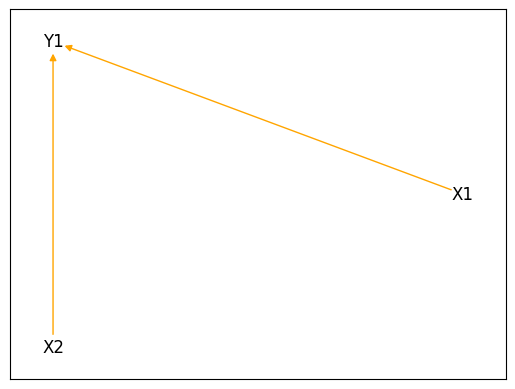

In [25]:
grn.plot_network()

Finally, we can run some simulations to test the dynamics of the established network:


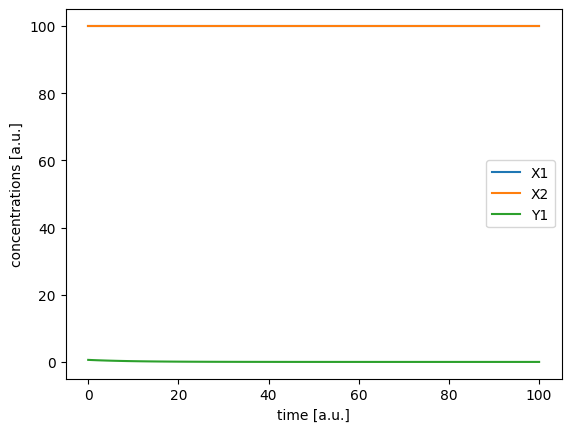

In [26]:
import numpy as np

# specify inputs
IN = np.zeros(len(grn.input_species_names))
IN[0] = 100
IN[1] = 100

T, Y = simulator.simulate_single(grn, IN)

The simulations can also be performed for a sequence of inputs. In this case, we also need to specify for how long each input combination will be held (`t_single`).


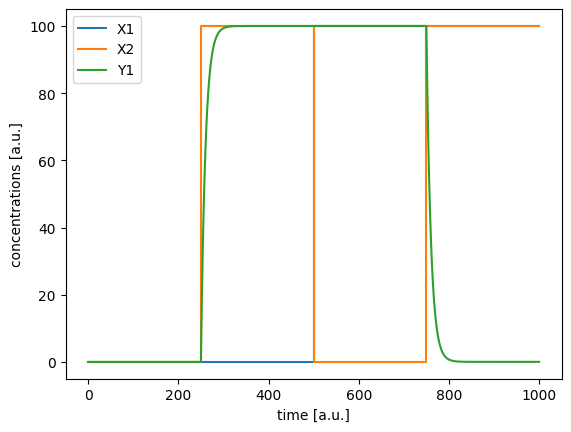

In [27]:
T, Y = simulator.simulate_sequence(
    grn, [(0, 0), (0, 100), (100, 0), (100, 100)], t_single=250
)

We can observe the following dynamics:

- For the first 250 time units, both inputs (`X1` and `X2`) are absent (logical 0) and so is the output (`Y`).
- The next 250 time units (from `t=250 a.u.` to `t=500 a.u.`) the first input (`X1`) is absent (logical 0) and the second output (`X2`) is present (logical 1). This activates the output (`Y`).
- The next 250 time units (from `t=500 a.u.` to `t=750 a.u.`) the first input (`X1`) is present (logical 1) and the second output (`X2`) is absent (logical 0). This activates the output (`Y`).
- The last 250 time units (from `t=750 a.u.` to `t=1000 a.u.`) both inputs (`X1` and `X2`) are present (logical 1). This inactivates the output (`Y`).


## Boolean network

GRN objects can be used to construct Boolean networks. The code is implemented in `src/bool_sim.py`.
First, let us create a more interesting network: an oscilator with 3 genes.

In [36]:
grn_builder = Builder()

X = grn_builder.species("X", 0.1)
Y = grn_builder.species("Y", 0.1)
Z = grn_builder.species("Z", 0.1)

grn_builder.gene([Z.represses(Kd=1, n=2)], [X])
grn_builder.gene([X.represses(Kd=1, n=2)], [Y])
grn_builder.gene([Y.represses(Kd=1, n=2)], [Z])

oscilator_grn = grn_builder.grn

In [37]:
from src.bool_sim import BooleanNetwork

bool_network = BooleanNetwork(oscilator_grn)

Boolean networks allow us to print their boolean rules, plot the interaction and state transition graphs.

**Currently, there is no distinction between activations and inhibitions in the visualizations. They show only the presence of an interaction between two genes and not the type of interaction.**

Boolean rules:
var_X = ((1) & (!var_Z))
var_Y = ((1) & (!var_X))
var_Z = ((1) & (!var_Y))


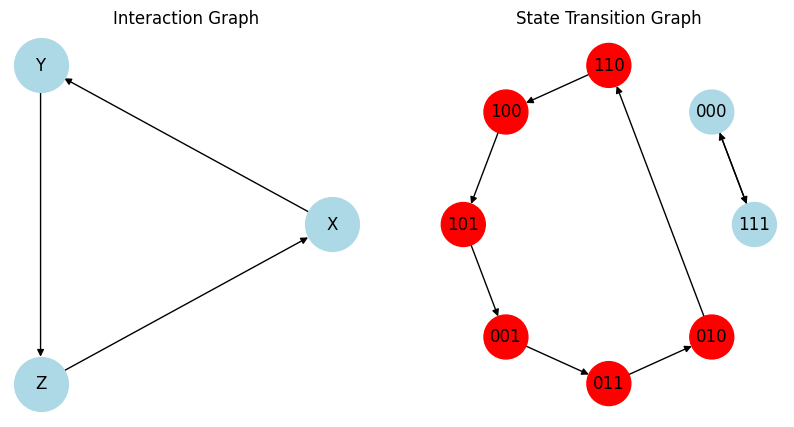

In [42]:
import matplotlib.pyplot as plt

# print boolean rules
bool_network.print_rules()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot the interaction graph
bool_network.plot_interaction_graph(ax=ax[0])

# plot the state transition graph
bool_network.plot_state_transitions(ax=ax[1])

We can also simulate the network for a given number of steps and initial state. The simulation supports two modes: sync and async.

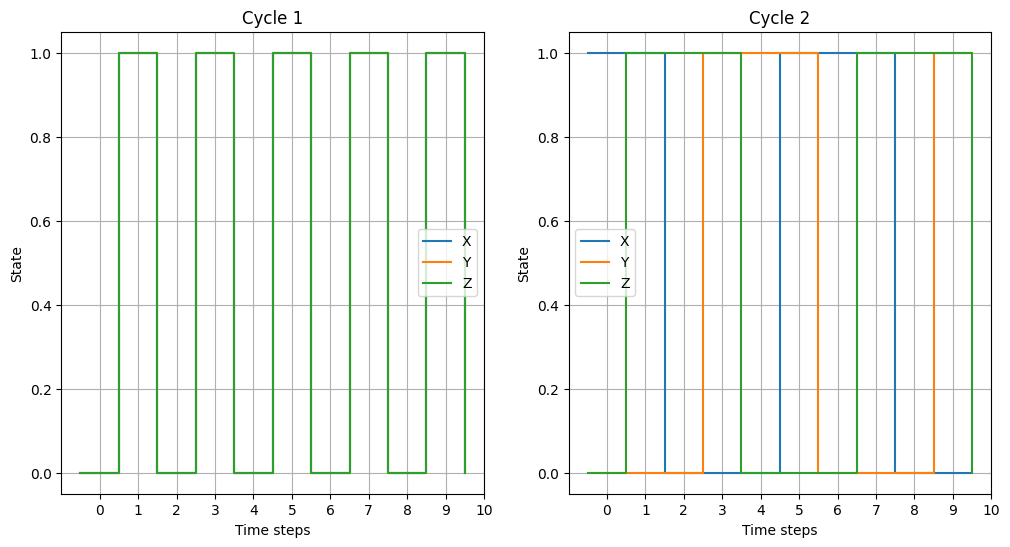

In [40]:
from src.utils import plot_trajectory

initial_state = {"X": 0, "Y": 0, "Z": 0}
trajectory1 = bool_network.simulate(initial_state, "sync", 10)

initial_state = {"X": 1, "Y": 0, "Z": 0}
trajectory2 = bool_network.simulate(initial_state, "sync", 10)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_trajectory(trajectory1, oscilator_grn.species_names, "Cycle 1", ax=ax[0])
plot_trajectory(trajectory2, oscilator_grn.species_names, "Cycle 2", ax=ax[1])
plt.show()

## Qualitative network

Currently, only reading from SBML files is supported. ODEs and Boolean networks can't be automatically converted to qualitative networks. The code is implemented in `src/qual_sbml.py`.

In [41]:
from src.qual_sbml import QualModel

qual_model = QualModel("qualSBML/regulator.xml")

Same as Boolean networks, the qualitative model can be visualized and simulated.

**Currently, there is no distinction between activations and inhibitions in the visualizations. They show only the presence of an interaction between two genes and not the type of interaction.**

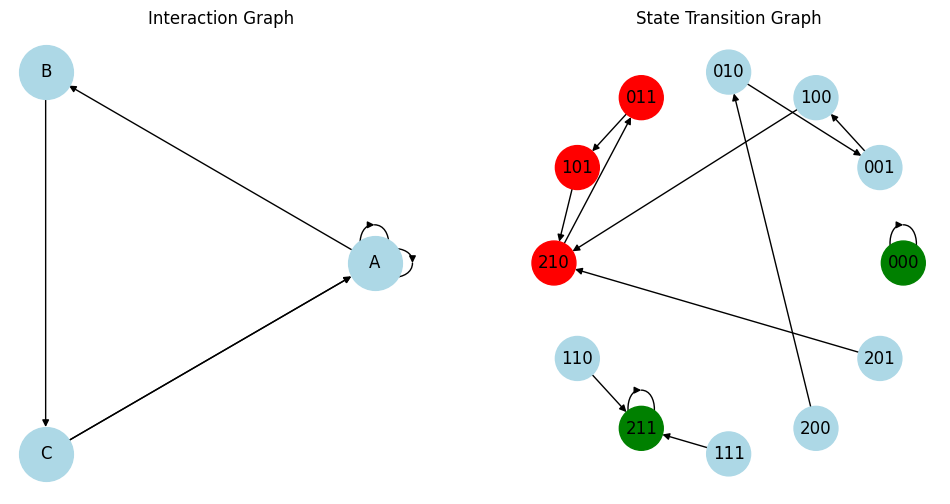

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
qual_model.plot_interaction_graph(ax=ax[0])
qual_model.plot_state_transitions(ax=ax[1])
plt.show()

In the above state transtion graph we can see three different attractors. Let's simulate the network and plot trajectories for each attractor.

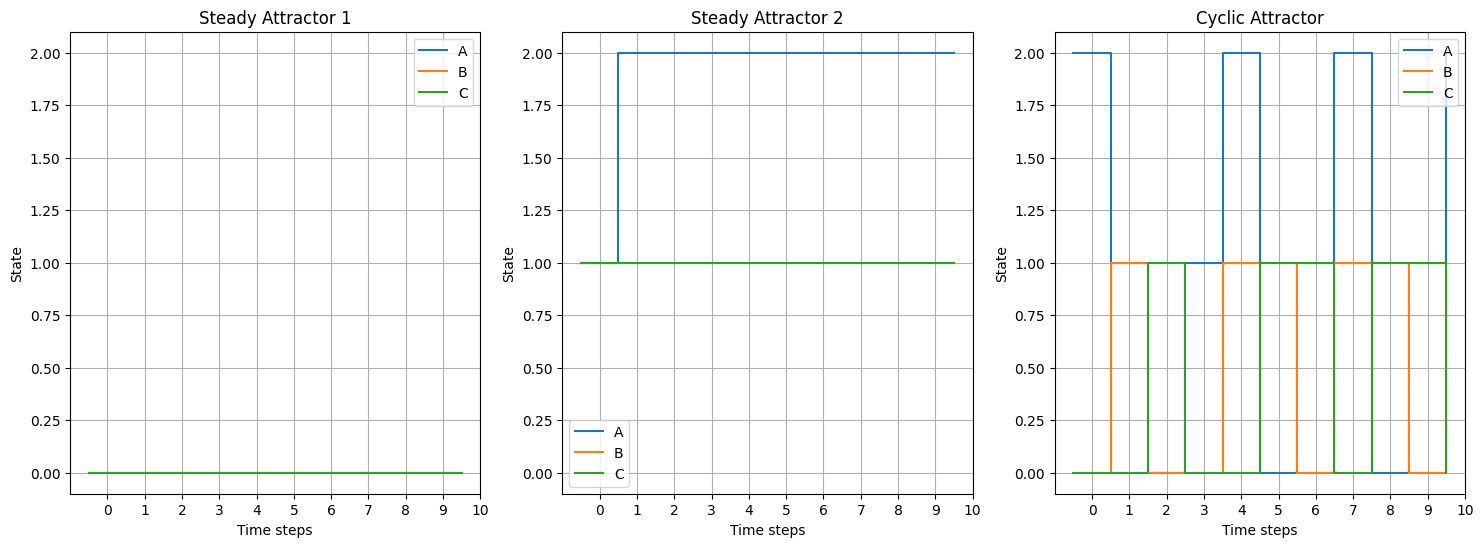

In [44]:
trajectory1 = qual_model.simulate({"A": 0, "B": 0, "C": 0}, steps=10)
trajectory2 = qual_model.simulate({"A": 1, "B": 1, "C": 1}, steps=10)
trajectory3 = qual_model.simulate({"A": 2, "B": 0, "C": 0}, steps=10)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plot_trajectory(
    trajectory1,
    qual_model.species,
    "Steady Attractor 1",
    ax=ax[0],
    ymin=-0.1,
    ymax=2.1,
)
plot_trajectory(
    trajectory2,
    qual_model.species,
    "Steady Attractor 2",
    ax=ax[1],
    ymin=-0.1,
    ymax=2.1,
)
plot_trajectory(
    trajectory3,
    qual_model.species,
    "Cyclic Attractor",
    ax=ax[2],
    ymin=-0.1,
    ymax=2.1,
)
plt.show()